[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs/mnist_tutorial.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs/mnist_tutorial.ipynb)

# MNIST Tutorial

Welcome to NNX! This tutorial will guide you through building and training a simple convolutional 
neural network (CNN) on the MNIST dataset using the NNX API. NNX is a Python neural network library
built upon [JAX](https://github.com/google/jax) and currently offered as an experimental module within 
[Flax](https://github.com/google/flax).

## 1. Install NNX

Since NNX is under active development, we recommend using the latest version from the Flax GitHub repository:

In [ ]:
# TODO: Fix text descriptions in this tutorial
!pip install git+https://github.com/google/flax.git

## 2. Load the MNIST Dataset

We'll use TensorFlow Datasets (TFDS) for loading and preparing the MNIST dataset:

In [1]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

tf.random.set_seed(0) # set random seed for reproducibility

num_epochs = 10
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(lambda sample: {
  'image': tf.cast(sample['image'],tf.float32) / 255,
  'label': sample['label']}) # normalize train set
test_ds = test_ds.map(lambda sample: {
  'image': tf.cast(sample['image'], tf.float32) / 255,
  'label': sample['label']}) # normalize test set

train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

## 3. Define the Network with NNX

Create a convolutional neural network with NNX by subclassing `nnx.Module`.

In [9]:
from flax.experimental import nnx  # NNX API

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(in_features=1, out_features=32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(in_features=32, out_features=64, kernel_size=(3, 3), rngs=rngs)
    self.linear1 = nnx.Linear(in_features=3136, out_features=256, rngs=rngs)
    self.linear2 = nnx.Linear(in_features=256, out_features=10, rngs=rngs)

  def __call__(self, x):
    x = self.conv1(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = self.conv2(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.linear1(x)
    x = nnx.relu(x)
    x = self.linear2(x)
    return x

model = CNN(rngs=nnx.Rngs(0))

print(f'model = {model}'[:500] + '\n...\n')  # print a part of the model
print(f'{model.conv1.kernel.value.shape = }') # inspect the shape of the kernel of the first convolutional layer

model = CNN(
  conv1=Conv(
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask_fn=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x3649501f0>,
      bias_init=<function zeros at 0x322e3d940>,
      conv_general_dilated=<funct
...

model.conv1.kernel.value.shape = (3, 3, 1, 32)


### Run model

Let's put our model to the test!  We'll perform a forward pass with arbitrary data and print the results.

In [10]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
y

Array([[-0.06820839, -0.14743432,  0.00265857, -0.2173656 ,  0.16673787,
        -0.00923921, -0.06636689,  0.28341877,  0.33754364, -0.20142877]],      dtype=float32)

## 4. Define Metrics

To track our model's performance, we'll use the [clu](https://github.com/google/CommonLoopUtils) library. If you haven't already, install it with:

In [ ]:
!pip install -q clu

Let's create a compound metric using clu.metrics.Collection.  This will include both an Accuracy metric for tracking how well our model classifies images, and an Average metric to monitor the average loss over each training epoch.

In [ ]:
# from clu import metrics
# from flax import struct   # Flax pytree dataclasses

# @struct.dataclass
# class Metrics(metrics.Collection):
#   accuracy: metrics.Accuracy
#   loss: metrics.Average.from_output('loss')

## 5. Create the `TrainState`

In Flax, a common practice is to use a dataclass to encapsulate the training state, including the step number, parameters, and optimizer state. The [`flax.training.train_state.TrainState`](https://flax.readthedocs.io/en/latest/flax.training.html#train-state) class is ideal for basic use cases, simplifying the process by allowing you to pass a single argument to functions like `train_step`.

In [11]:
import optax
import dataclasses

@dataclasses.dataclass
class TrainState(nnx.GraphNode):
  optimizer: nnx.Optimizer
  model: CNN
  metrics: nnx.MultiMetric

learning_rate = 0.005
momentum = 0.9

tx = optax.adamw(learning_rate, momentum)
state = TrainState(
  optimizer=nnx.Optimizer(model=model, tx=tx),
  model=model,
  metrics=nnx.MultiMetric(accuracy=nnx.metrics.Accuracy(), loss=nnx.metrics.Average()),
)

Since `TrainState` is a JAX pytree, `Module.split` splits the model into `State` and `GraphDef` pytree objects (representing parameters and the graph definition). A custom `TrainState` type holds the static `GraphDef` and metrics.  We use `optax` to create an optimizer (`adamw`) and initialize the `TrainState`.

## 6. Training step

This function takes the `state` and a data `batch` and does the following:

* Reconstructs the model with `static.merge` on the `params`.
* Runs the neural network on the input image batch.
* Calculates cross-entropy loss using 
  [optax.softmax_cross_entropy_with_integer_labels()](https://optax.readthedocs.io/en/latest/api.html#optax.softmax_cross_entropy_with_integer_labels). Integer labels eliminate the need for one-hot encoding.
* Computes the loss function's gradient with `jax.grad`.
* Updates model parameters by applying the gradient pytree to the optimizer.

In [12]:
def loss_fn(model, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss, logits

@nnx.jit
def train_step(state: TrainState, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.model, batch)
  state.metrics.update(values=loss, logits=logits, labels=batch['label'])
  state.optimizer.update(grads=grads)

The [@jax.jit](https://jax.readthedocs.io/en/latest/jax.html#jax.jit) decorator
traces the `train_step` function for just-in-time compilation with 
[XLA](https://www.tensorflow.org/xla), optimizing performance on 
hardware accelerators.

## 7. Metric Computation

Create a separate function to calculate loss and accuracy metrics. Loss is determined using the `optax.softmax_cross_entropy_with_integer_labels` function, and accuracy is computed using `clu.metrics`.

In [13]:
@nnx.jit
def compute_test_metrics(*, state: TrainState, batch):
  loss, logits = loss_fn(state.model, batch)
  state.metrics.update(values=loss, logits=logits, labels=batch['label'])

## 9. Seed randomness

For reproducible dataset shuffling (using `tf.data.Dataset.shuffle`), set the TF random seed.

In [14]:
tf.random.set_seed(0)

## 10. Train and Evaluate

**Dataset Preparation:** create a "shuffled" dataset
- Repeat the dataset for the desired number of training epochs.
- Establish a 1024-sample buffer (holding the dataset's initial 1024 samples).
  Randomly draw batches from this buffer.
- As samples are drawn, replenish the buffer with subsequent dataset samples.

**Training Loop:** Iterate through epochs
- Sample batches randomly from the dataset.
- Execute an optimization step for each training batch.
- Calculate mean training metrics across batches within the epoch.
- With updated parameters, compute metrics on the test set.
- Log train and test metrics for visualization.

After 10 training and testing epochs, your model should reach approximately 99% accuracy.

In [15]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': []
}

for step,batch in enumerate(train_ds.as_numpy_iterator()):
  # Run optimization steps over training batches and compute batch metrics
  train_step(state, batch) # get updated train state (which contains the updated parameters)

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    # log train metrics
    for metric, value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state.metrics.reset() # reset metrics for test set

    # Compute metrics on the test set after each training epoch
    for test_batch in test_ds.as_numpy_iterator():
      compute_test_metrics(state=state, batch=test_batch)

    # log test metrics
    for metric, value in state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    state.metrics.reset() # reset metrics for next training epoch

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.09993419796228409, accuracy: 96.87166595458984
test epoch: 1, loss: 0.056556060910224915, accuracy: 98.22715759277344
train epoch: 2, loss: 0.04524456709623337, accuracy: 98.59500122070312
test epoch: 2, loss: 0.04612208530306816, accuracy: 98.54767608642578
train epoch: 3, loss: 0.03335213661193848, accuracy: 99.00333404541016
test epoch: 3, loss: 0.03450154513120651, accuracy: 98.74800109863281
train epoch: 4, loss: 0.025704005733132362, accuracy: 99.1866683959961
test epoch: 4, loss: 0.054902084171772, accuracy: 98.5977554321289
train epoch: 5, loss: 0.022791478782892227, accuracy: 99.30166625976562
test epoch: 5, loss: 0.043014008551836014, accuracy: 98.94831848144531
train epoch: 6, loss: 0.019284944981336594, accuracy: 99.42500305175781
test epoch: 6, loss: 0.04867568239569664, accuracy: 98.6278076171875
train epoch: 7, loss: 0.017705166712403297, accuracy: 99.48666381835938
test epoch: 7, loss: 0.07197881489992142, accuracy: 98.40745544433594
train epoch:

## 11. Visualize Metrics

Use Matplotlib to create plots for loss and accuracy.

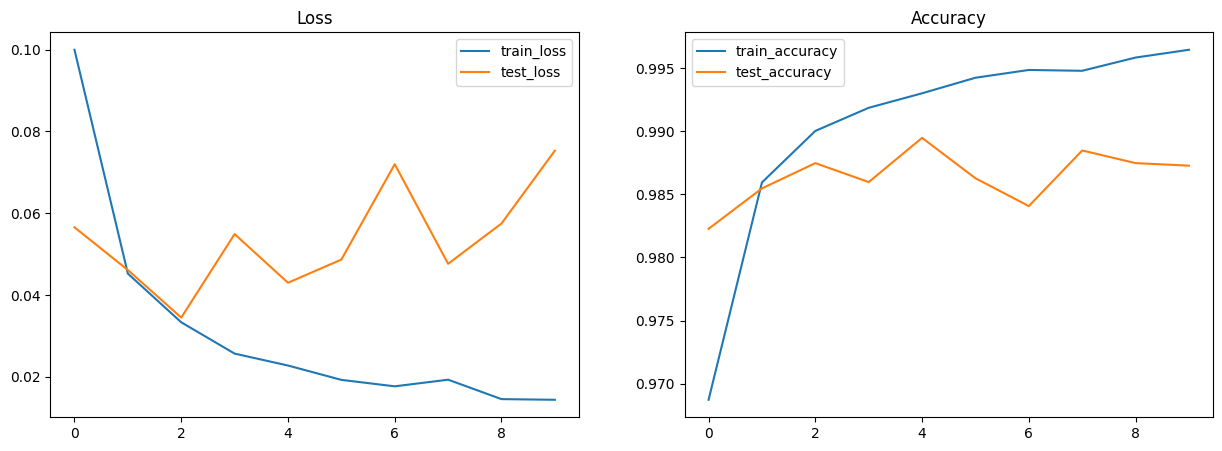

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 12. Perform inference on test set

Define a jitted inference function, `pred_step`, to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

In [17]:
@nnx.jit
def pred_step(state: TrainState, batch):
  logits = state.model(batch['image'])
  return logits.argmax(axis=1)

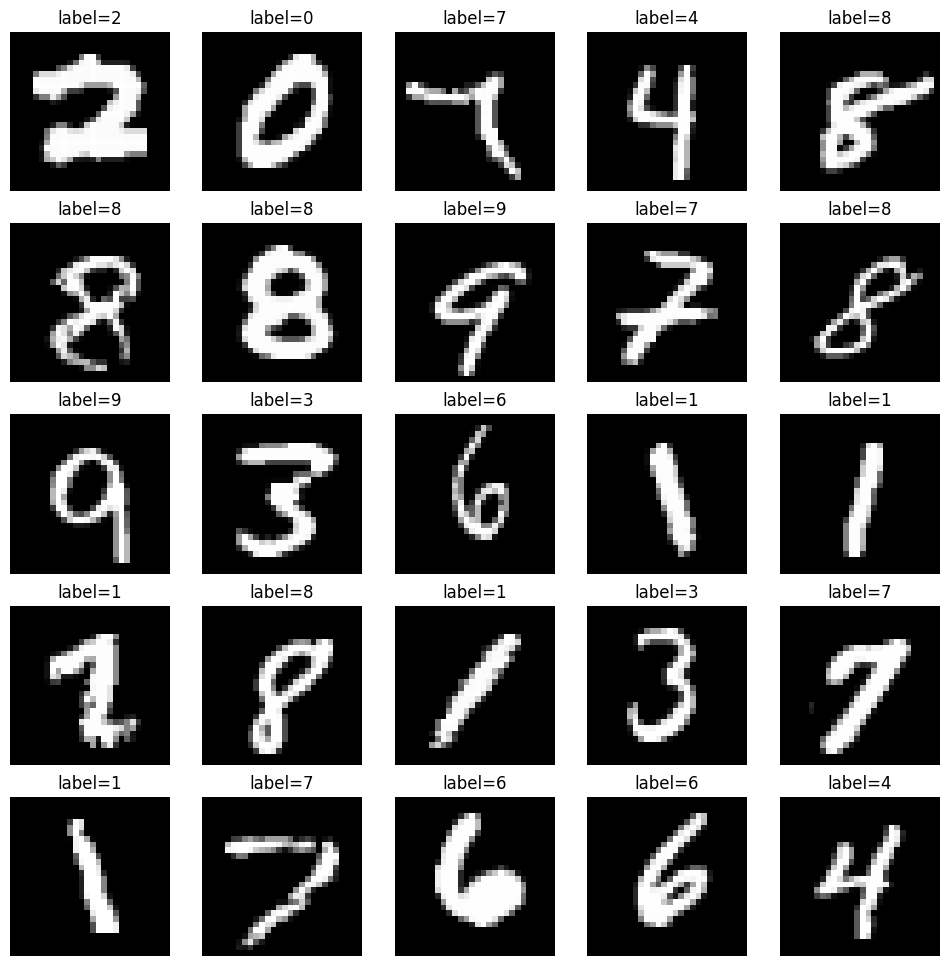

In [18]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f"label={pred[i]}")
  ax.axis('off')

Congratulations! You made it to the end of the annotated MNIST example.